### Imports

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/train/'
VAL_DATASET_PATH = '../data/val/'
TEST_DATASET_PATH = '../data/test/'

### Create Keras CNN Model

In [2]:
num_classes = 6
im_h, im_w = 100, 100

In [3]:
from keras.backend import clear_session

clear_session()
model = None

Using TensorFlow backend.


In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam, Adadelta
from keras.metrics import categorical_accuracy

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding='valid', input_shape=(im_w,im_h,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=[categorical_accuracy])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 128)      

### Create Data Iterators

In [5]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [14]:
BS = 64

train_it = datagen.flow_from_directory(DATASET_PATH, class_mode='categorical', target_size=(im_h,im_w), color_mode='grayscale', batch_size=BS)
val_it = datagen.flow_from_directory(VAL_DATASET_PATH, class_mode='categorical', target_size=(im_h,im_w), color_mode='grayscale', batch_size=BS)
test_it = datagen.flow_from_directory(TEST_DATASET_PATH, class_mode='categorical', target_size=(im_h,im_w), color_mode='grayscale', batch_size=BS)

Found 9000 images belonging to 6 classes.
Found 1350 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.


### Train CNN

In [15]:
nb_train_steps = train_it.samples // train_it.batch_size
nb_val_steps = val_it.samples // val_it.batch_size

In [16]:
from keras.callbacks import EarlyStopping
EPOC = 25

es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1)
# history = model.fit(xtrain, ytrain_cat, validation_split=0.2, batch_size=BS, epochs=EPOC, callbacks=[es])

In [17]:
history = model.fit_generator(
    train_it,
    steps_per_epoch=nb_train_steps,
    epochs=EPOC,
    validation_data=val_it,
    validation_steps=nb_val_steps, 
    callbacks=[es]
)

Epoch 1/25
140/140 [==============================] - 24s 173ms/step - loss: 3.2322 - categorical_accuracy: 0.5547 - val_loss: 0.9241 - val_categorical_accuracy: 0.7597
Epoch 2/25
140/140 [==============================] - 20s 141ms/step - loss: 0.4553 - categorical_accuracy: 0.8723 - val_loss: 0.5002 - val_categorical_accuracy: 0.8826
Epoch 3/25
140/140 [==============================] - 22s 159ms/step - loss: 0.3722 - categorical_accuracy: 0.9364 - val_loss: 0.2930 - val_categorical_accuracy: 0.8935
Epoch 4/25
140/140 [==============================] - 19s 133ms/step - loss: 0.1539 - categorical_accuracy: 0.9556 - val_loss: 0.2922 - val_categorical_accuracy: 0.9331
Epoch 5/25
140/140 [==============================] - 21s 150ms/step - loss: 0.1126 - categorical_accuracy: 0.9705 - val_loss: 0.7197 - val_categorical_accuracy: 0.7869
Epoch 6/25
140/140 [==============================] - 22s 155ms/step - loss: 0.0483 - categorical_accuracy: 0.9825 - val_loss: 0.2612 - val_categorical_acc

In [18]:
history.params

{'epochs': 25,
 'steps': 140,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'val_loss',
  'val_categorical_accuracy']}

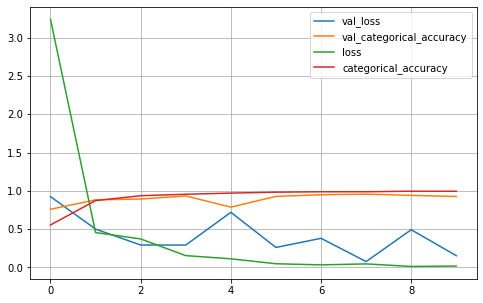

In [19]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

### Check accuracy on test dataset

In [20]:
model.evaluate_generator(test_it)

[0.0003340882249176502, 0.9611111283302307]

### Check confusion matrix

In [21]:
import pandas as pd
ypred = model.predict_classes(xtest)

confmatr = pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)
confmatr

NameError: name 'xtest' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix

confmatr = confusion_matrix(ytest, ypred)
row_sums = confmatr.sum(axis=1,keepdims=True)
norm_conf_matr = confmatr / row_sums
np.fill_diagonal(norm_conf_matr,0)
plt.matshow(norm_conf_matr,cmap=plt.cm.gray);

### Save model.

In [ ]:
model.save('../models/model_cnn.h5')

### Try our model on a never seen before picture (original one)

In [ ]:
from keras.models import load_model
mymodel = load_model('../models/model_cnn.h5')

In [ ]:
files = os.listdir(TEST_DATASET_PATH)
idx = random.randint(0,len(files)-1)
origimg = cv2.imread(os.path.join(TEST_DATASET_PATH,files[idx]),cv2.IMREAD_GRAYSCALE)

myimg = origimg/255.
myimg = cv2.resize(myimg,(im_h, im_w))
myimg = myimg.reshape(1,im_h, im_w,1)

myclass = mymodel.predict(myimg)
pred = np.argmax(myclass)

plt.imshow(origimg, cmap='gray');
plt.title('y=%d' % pred);
plt.axis('off');


In [ ]:
plot_6_images(xtest,ypred)